## init

In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms

import sys
sys.path.insert(0, '/root/git/hetcattoolbox')

import seaborn as sns
import pandas as pd
import numpy as np
import ast

In [63]:
from autoadsorbate.string_utils import _example_config, _show_ussage, construct_smiles, xx_get_special_symbols
from autoadsorbate.autoadsorbate import Fragment, Surface
from autoadsorbate.Surf import conformer_to_site
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O
from autoadsorbate.plotting import *

In [7]:
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import plotly.express as px
from ase.build.tools import sort as sort_atoms
from autoadsorbate.utils import get_backbone_bond_change,read_relax_traj,  read_relax_dir, compute_energy, snap_pos_compare
from autoadsorbate.utils import _compare_pos, slice_traj_by_formula,  get_drop_snapped, count_C_next_to_O

## aads MACE relaxed intermediates

In [ ]:
# # all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
# all_files = glob('./prep/relax/MACE*.xyz')
# len(all_files)

# rdf, relaxed_traj = read_relax_dir(all_files)
# _ = rdf.pop('site')
# rdf['origin'] = ['aads' for _ in rdf['uid']]

In [ ]:
# from mace.calculators import mace_mp

# ref_atoms = relaxed_traj[0].copy()[[atom.index for atom in relaxed_traj[0] if atom.symbol == 'Cu']]
# calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
# ref_atoms.set_calculator(calc)
# parent_en = ref_atoms.get_potential_energy()

# ref_dict={
#     'C' : 0,
#     'O' : 0,
#     'H' : 0
# }

# # parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

# xdf = compute_energy(rdf, ref_dict, parent_en)
# xdf = xdf[xdf['energy']>-100]

### chemiscope

In [ ]:
# xdf = pd.read_csv('relaxed_traj.csv')
# relaxed_traj = read('relaxed_traj.xyz', index=':')

In [ ]:
# _xdf = filter_xdf(xdf, relaxed_traj)

In [ ]:
# len(_xdf.smiles.unique())

In [ ]:
# chemiscope.show(
#     frames=[relaxed_traj[i] for i in _xdf.traj_index.values],
#     properties=_xdf.to_dict(orient='list'),
#     mode='default',
# )

In [ ]:
chemiscope.write_input(
    frames=[center_fragment_in_cell(relaxed_traj[i], fragment_inds=[1]) for i in _xdf.traj_index.values],
    properties=_xdf.to_dict(orient='list'),
    path='chemiscope_input.json'
    # mode='default',
)

### plot atoms

In [ ]:
plot_most_stable(_xdf, relaxed_traj)

In [ ]:
make_hist_plot(_xdf)

In [ ]:
ax, heat_map = plot_energy_heatmap(_xdf,
                    column = 'energy_calibrated',
                    std = 0.05,
                    e_min=-0.1,
                    e_max=3,
                    resolution='auto',
                    normalize=True,
                    return_heatmap=True,
                    T=True,
                    cmap = "Blues"
                    )

In [ ]:
ax, heat_map = plot_energy_heatmap(_xdf,
                    column = 'energy_calibrated',
                    std = 0.05,
                    # e_max=_xdf.energy_calibrated.max()+5*std,
                    # e_min=_xdf.energy_calibrated.min()-5*std,
                    e_min=-0.1,
                    e_max=3,
                    resolution='auto',
                    normalize=False,
                    return_heatmap=True,
                    T=True)

In [ ]:
# sns.stripplot(
#     data=_xdf, x="total_bill", y="day", hue="time",
#     jitter=False, s=20, marker="D", linewidth=1, alpha=.1,
# )

## paper prep

In [2]:
# # all_files = glob('./RELAX/relax_Cu211_get_population/prerelax/MACE*.xyz')
# all_files = glob('./relax_*/MACE*.xyz')
# mpid=[[n for n in file.split('_') if 'mp-' in n][0] for file in all_files]
# pid =[[n for n in all_files[0].split('/') if '#' in n][0] for file in all_files]

# # rdf, relaxed_traj = read_relax_dir(all_files)
# # _ = rdf.pop('site')
# # rdf['origin'] = ['aads' for _ in rdf['uid']]

# # # rdf['mpid'] = mpid

In [35]:
relaxed_traj = read('./collect_junwu/relaxed_traj.xyz', index=':')
rdf = pd.read_csv('./collect_junwu/data_rdf.csv')
pid = [f"{ast.literal_eval(d)['mpid']}_{ast.literal_eval(d)['mi']}_{ast.literal_eval(d)['iterm']}" for d in rdf.slab_info.values]
rdf['pid'] = pid

In [36]:
len(relaxed_traj) == len(rdf)

True

In [37]:
from mace.calculators import mace_mp

parent_en = {}
for pid in rdf.pid.unique():
    traj_index = rdf[rdf.pid.isin([pid])].traj_index.iloc[0]
    atoms = relaxed_traj[traj_index].copy()
    ref_atoms = atoms[[atom.index for atom in atoms if atoms.arrays['fragments'][atom.index] == 0]]
    calc = mace_mp(model='./models/mace-mp-0b3-medium.model', dispersion=True, device='cpu')
    ref_atoms.set_calculator(calc)
    parent_en[pid] = ref_atoms.get_potential_energy()
    ref_atoms.info={'pid': pid}

ref_dict={
    'C' : 0,
    'O' : 0,
    'H' : 0
}

# parent_en = read('./relax_Cu111_Cu2_try2/MACE_relax_Cu111_Cu2_slab.xyz', index=-1).get_potential_energy()

xdf = compute_energy(rdf, ref_dict, parent_en)
# xdf = xdf[xdf['energy']>-100]

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_locatio

Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_137697/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_locatio

Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_137697/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_locatio

Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_137697/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_locatio

Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_137697/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_locatio

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_locatio

Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


/tmp/ipykernel_137697/3835913130.py:9: FutureWarning: Please use atoms.calc = calc
  ref_atoms.set_calculator(calc)


In [38]:
_xdf = filter_xdf(xdf, relaxed_traj)

/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/autoadsorbate/plotting.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['C_bonds_O'] = C_bonds_O
/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/autoadsorbate/plotting.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['backbone'] = backbone
/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/autoadsorbate/plotting.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

remaining values in DF: 44510


/home/djrm/miniconda3/envs/aads/lib/python3.12/site-packages/autoadsorbate/plotting.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _xdf['H_max'] = [map_H_max[_xdf.backbone_formula.values[i]] for i in range(len(_xdf))]


<Axes: xlabel='energy_calibrated', ylabel='Count'>

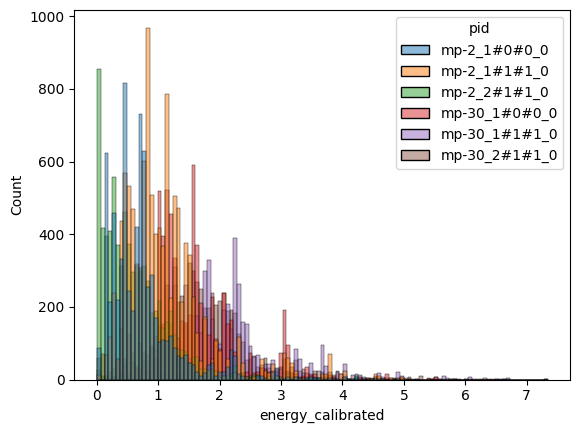

In [40]:
sns.histplot(_xdf, x='energy_calibrated', hue='pid')

In [58]:
_xdf['mi'] = [v.split('_')[1] for v in _xdf.pid.values]

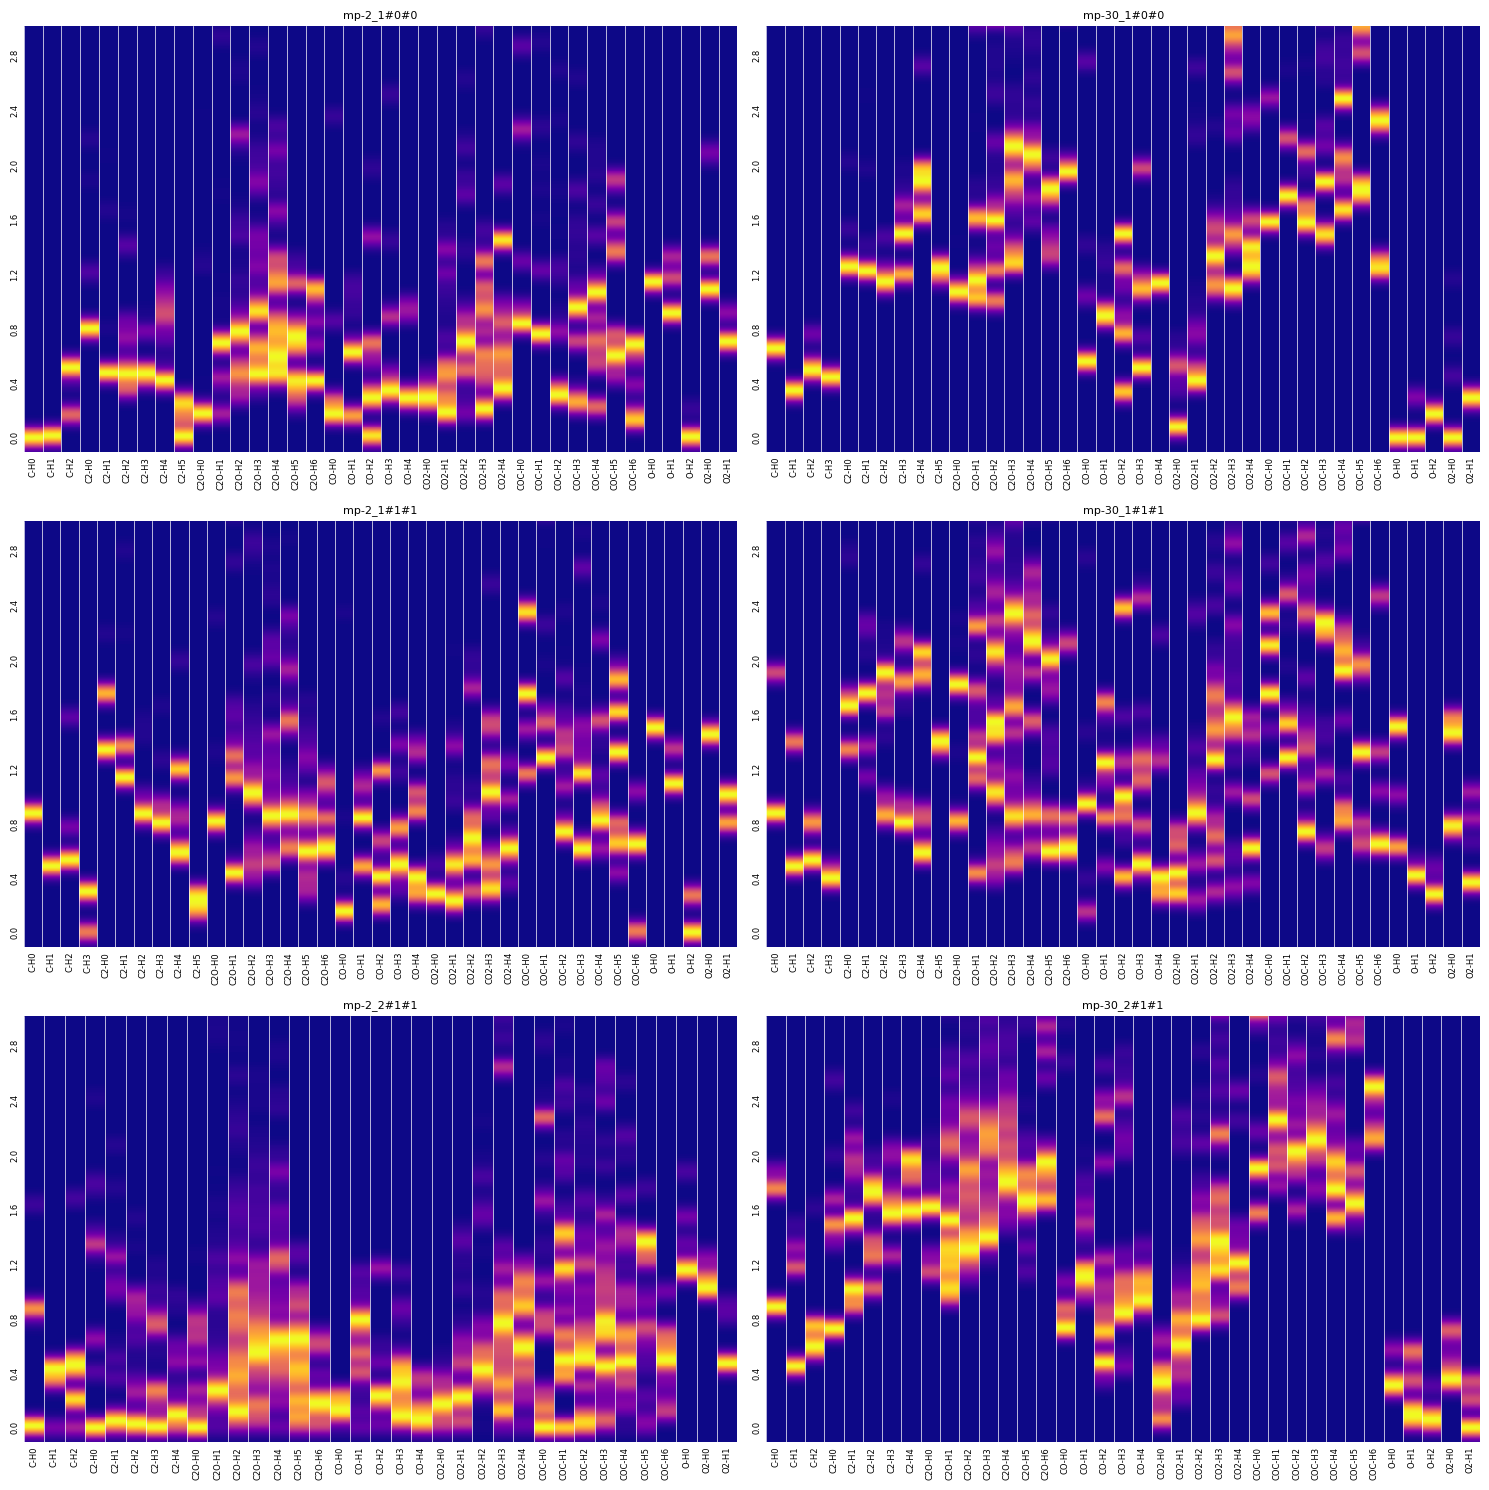

In [72]:
mis = _xdf.mi.unique()
mpids = _xdf.mpid.unique()

fig, axs = plt.subplots(len(mis), len(mpids), figsize=[15,15])

num_dict = {}

for i, mpid in enumerate(mpids):
    for j, mi in enumerate(mis):

        pdf = _xdf[_xdf.mi.isin([mi]) & _xdf.mpid.isin([mpid])]
        pdf = pdf.sort_values(by=['calibrate_keys'])

        heat_map = plot_energy_heatmap(pdf,
                            column = 'energy_calibrated',
                            std = 0.05,
                            e_min=-0.1,
                            e_max=3,
                            resolution='auto',
                            normalize=True,
                            normalize_mode='max',
                            return_heatmap=True,
                            cmap='plasma',
                            T=True,
                            ax=axs[j,i])
        axs[j,i].set_title(f'{mpid}_{mi}', fontdict = {'fontsize': 8})
        num_dict[f"{mpid}_{mi}_0"] = heat_map

fig.set_layout_engine(layout='tight')

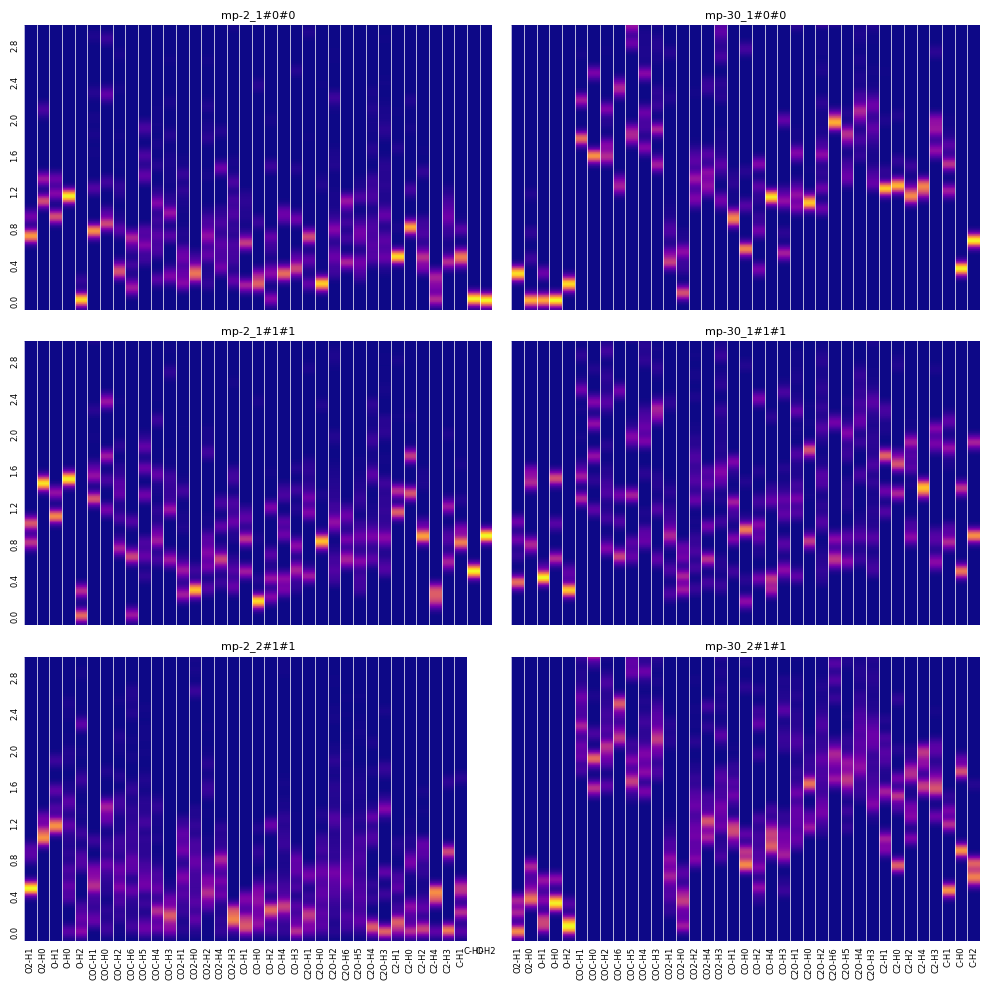

In [117]:
mis = _xdf.mi.unique()
mpids = _xdf.mpid.unique()

fig, axs = plt.subplots(len(mis), len(mpids), figsize=[10,10], sharex=True, sharey=True)

num_dict = {}

for i, mpid in enumerate(mpids):
    for j, mi in enumerate(mis):

        pdf = _xdf[_xdf.mi.isin([mi]) & _xdf.mpid.isin([mpid])]
        pdf = pdf.sort_values(by=['calibrate_keys'], ascending=False)

        heat_map = plot_energy_heatmap(pdf,
                            column = 'energy_calibrated',
                            std = 0.05,
                            e_min=-0.1,
                            e_max=3,
                            resolution='auto',
                            normalize=True,
                            normalize_mode='integral',
                            return_heatmap=True,
                            cmap='plasma',
                            T=True,
                            ax=axs[j,i])
        axs[j,i].set_title(f'{mpid}_{mi}', fontdict = {'fontsize': 8})
        num_dict[f"{mpid}_{mi}_0"] = heat_map

fig.set_layout_engine(layout='tight')

<Axes: >

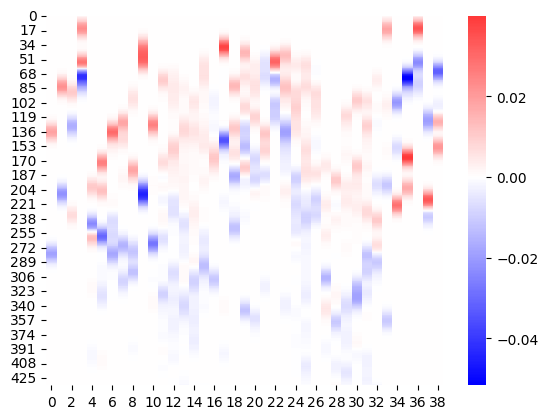

In [89]:
sns.heatmap(num_dict['mp-2_1#1#1_0'].T - num_dict['mp-30_1#1#1_0'].T, cmap='bwr', center=0)

In [ ]:
plot_most_stable(_xdf, relaxed_traj)

In [ ]:
make_hist_plot(_xdf)

In [ ]:
# import os
# import json
# import numpy as np
# from ase.io import read

# path = './collect_junwu/'

# with open(os.path.join(path, 'identifiers.json')) as f:
#     identifiers = json.load(f)

# energy_array = np.load(os.path.join(path, 'energy_array.npy'))
# smiles = [i.split('--')[1] for i in identifiers]
# pid = [i.split('--')[0].split('elax_')[-1] for i in identifiers]
# relaxed_traj = read(os.path.join(path, 'relaxed_traj.xyz'), index=':')
# parent_traj = read(os.path.join(path, 'parent_traj.xyz'), index=':')

In [90]:
from ase.build import fcc111

In [91]:
slab = fcc111('Cu', [3,3,3], vacuum=10)

In [92]:
from autoadsorbate import Surface, Fragment

In [96]:
view(slab*[5,5,1])

<Popen: returncode: None args: ['/home/djrm/miniconda3/envs/aads/bin/python'...>

In [94]:
s = Surface(slab)

In [97]:
s.view_surface()

Visualizing surface Cu atoms as Zn


In [103]:
view([slab.copy()+s.view_site(i, return_atoms=True) for i in s.site_df.index.values])

<Popen: returncode: None args: ['/home/djrm/miniconda3/envs/aads/bin/python'...>

In [102]:
# s.site_df

In [115]:
f = Fragment('S1s[O]CC[O]1')
# f = Fragment('S1s[OH+]C=C[OH+]1')

In [116]:
view(f.get_conformer(0))

<Popen: returncode: None args: ['/home/djrm/miniconda3/envs/aads/bin/python'...>

In [ ]:
view([f.get_conformer(i) for i in [1,2,3]])

<Popen: returncode: None args: ['/home/djrm/miniconda3/envs/aads/bin/python'...>

In [110]:
# s.site_df

In [ ]:
1 - 1, 5 6, 7 (SMI1)
2 0 0 0 0 0 0 (SMI2)
3 - 2 4 5 6 6 (SMI@)
4 0 0 0 0 0 0
5 0 0 0 0 0 0 > ase atoms > e



